In [1]:
import matplotlib.pyplot as plt
import numpy as np

from common import load_iris, make_cdf

#  Hypothesis Testing

References:
- Chapter 9 of [Think Stats 2nd Edition](https://greenteapress.com/wp/think-stats-2e/)
- Chapter 3 of [Practical Statistics for Data Scientists](https://www.oreilly.com/library/view/practical-statistics-for/9781491952955/).
- [Statistics Done Wrong - Alex Reinhart](https://www.statisticsdonewrong.com/)
- [Statistics for Hackers - PyCon 2016 - Jake Vanderplas](https://www.youtube.com/watch?v=Iq9DzN6mvYA)

## Did I get lucky?

You will always observe effects in data due to chance.  
- what is the probability of seeing this effect by chance?
- **is this effect likely to appear in the larger population**?

No tool can tell you if your hypothesis is really true
- only if is is consistent with the data

## Analytic computation versus simulating

Computing the sampling distribution is hard 
- **simulating the sampling distribution is easy**

With analytical statistical testing (i.e. Welch's t-testing) 
- we lose track of what question we are asking
- often limited by assumptions of normality or to work with certain data types

Sampling/simulation methods
- allow intuition in the place of statistical rules
- can use for loops to do statistical analysis (often averaging over the runs)

Four recipes
1. direct simulation
2. shuffling - permutation
3. bootstrapping
4. cross-validation

## Hypothesis testing

We design experiments to **accept or reject a hypothesis**
- in the context of experiment design, *inference* refers to applying the experiment results to a larger population after the conclusion is made

Proof by *reductio ad absurdum* 
- assume that A is false
- find a contradiction -> A is true

Procedure
1. choose a test statistic
2. define a null hypothesis
3. compute a p-value
4. interpret the result

The assumption we make is the **null hypothesis** - that the effect is not real
- we compute a probability (**p value**) based on that assumption
- low probability -> null nypothesis false -> effect is real

Limitations
- only tells you if the effect is larger than what could be produced by luck
- not that the effect is actually significant

Possible to measure a small effect with great certanitiy
- we can use hypothesis testing to confirm that a 0.001 difference in customers is statistically significant with a p-value of 96%

## The p-value

The probability of collecting of collecting data that shows an effect equal/greater than observed.  

How likely is the dataset, if we assume the true effect is zero.  It is a **measurement of suprise**.

The p-value is controversial 
- in 2015 the journal Basic and Applied Social Psychology (BASP) stopped publishing papers containing P values because the statistics were too often used to support lower-quality research
- p-value hacking (a form of sample bias) is common

We want a p-value to give us the probability that an observed effect is due to chance
- in reality, the p-value represents the probability that given a random model, results as extreme as we observe can occur

For industry based data scientists, who are free from pressure to publish, the p-value is a useful metric that can inform about whether an obeserved effect is due to chance or not.  
- it is a single point of infomation (amoung many others) used to inform an decision.

## [American Statistical Association 2016 Statement on p-values](https://www.amstat.org/asa/files/pdfs/P-ValueStatement.pdf)

1. p-values can indicate how incompatible the data are with a specified statistical model.
2. p-values do not measure the probability that the studied hypothesis is true, or the probability that the data were produced by random chance alone.
3. Scientific conclusions and business or policy decisions should not be based only on whether a p-value passes a specific threshold.
4. Proper inference requires full reporting and transparency.
5. A p-value, or statistical significance, does not measure the size of an effect or the importance of a result.
6. By itself, a p-value does not provide a good measure of evidence regarding a model or
hypothesis. 

## Significance

Probability threshold for significance (alpha) 
- 5% by convention.
- p-values less than an arbitrary threshold are very unlikely & hence significant

$ p < 0.05 $

No comment on the size of the effect 
- possible to measure a tiny effect with great certantity

## Jacob Bernoulli 

1655 - 1705.  Swiss mathematician.  Derived the first version of the Law of Large Numbers.  [Wikipedia](https://en.wikipedia.org/wiki/Jacob_Bernoulli).

![](assets/bernoulli.jpg)

The Bernoulli distribution is binary - the outcome is a single **bit of infomation** (0 or 1 - more on this in [entropy.ipynb]()):

In [2]:
data = load_iris()
features, target = data.features, data.target

def bernoulli(prob=0.5):
    return np.random.choice([0, 1], p=[1-prob, prob])

The Iris dataset was used in R.A. Fisher's classic 1936 paper *The Use of Multiple Measurements in Taxonomic Problems*.

features.shape = (150, 4)
target.shape = (150, 3)


The p-value for this binary variable is a simple ratio (an example of frequentist probability):

In [3]:
def p_value(samples):
    return sum(samples) / len(samples)

In [4]:
num = 200 
prob = 0.4

samples = [bernoulli(prob) for _ in range(num)]
samples[:5]

[1, 0, 0, 0, 0]

In [5]:
p_val = p_value(samples)
p_val

0.395

Now lets calculate the p-value for a biased coin, using a null hypothesis of a fair coin: 

In [13]:
def total_deviation(observed, expected):
    #  absolute error
    return abs(observed - expected)

def fair_coin(n):
    #  the simulation of the null hypothesis
    sample = [bernoulli(0.5) for _ in range(n)]
    return (n - sum(sample), sum(sample))

def calc_p_val(observed, n_trials, test_stat, null_hypothesis, iters=100):
    
    observed = total_deviation(*observed)

    #  simulating the null hypothesis
    test_stats = np.array([
        total_deviation(*null_hypothesis(n_trials)) for _ in range(iters)
    ])

    p_val = sum(test_stats > observed) / test_stats.shape[0]
    print('If the null hypothesis is true, we expect to see the effect of {} {} % of the time'.format(
        observed, p_val*100))
    
    return p_val
  
biased_coin = (140, 90)

p_val = calc_p_val(biased_coin, sum(biased_coin), total_deviation, fair_coin)

If the null hypothesis is true, we expect to see the effect of 50 0.0 % of the time


## Testing the difference in means

Let's do some hypothesis testing on some of the effects we can see in the Iris dataset

In [14]:
#  feature statistics per class
flowers = target.columns

for flower in flowers:
    print(flower)
    print(features[target[flower] == 1].describe().loc['mean', :])
    print(' ')

setosa
sepal length (cm)    5.006
sepal width (cm)     3.428
petal length (cm)    1.462
petal width (cm)     0.246
Name: mean, dtype: float64
 
versicolor
sepal length (cm)    5.936
sepal width (cm)     2.770
petal length (cm)    4.260
petal width (cm)     1.326
Name: mean, dtype: float64
 
virginica
sepal length (cm)    6.588
sepal width (cm)     2.974
petal length (cm)    5.552
petal width (cm)     2.026
Name: mean, dtype: float64
 


Lets investigate the difference in **sepal length** for **setosa versus virginica**

In [8]:
for flower in flowers:
    print(flower, features[target[flower] == 1].describe().loc['mean', 'sepal length (cm)'])
    print(' ')

setosa 5.006
 
versicolor 5.936
 
virginica 6.587999999999998
 


Our null hypothesis is that there is no difference
- we can model the null hypothesis by **shuffling**
- this is also known as permutation

Shuffling / permutation
- if the labels dont matter, then switching them shouldn't change the result
- only works with representative samples (non biased sampling)

Shuffling requires multiple groups

Let's run a hypothesis test

In [9]:
def test_means(observed, expected):
    return abs(np.mean(observed) - np.mean(expected))

def run_shuffle(pool):
    mask = np.random.randint(0, 2, size=pool.shape[0]).astype(bool)
    return pool[mask], pool[~mask]

def calc_p_val_mean_diff(first, second, iters=1000, test_stat=test_means):
    
    observed = test_stat(first, second)
    pool = np.concatenate([first, second])
    
    test_diff = np.array([
        test_stat(*run_shuffle(pool)) for _ in range(iters)
    ])

    p_val = sum(test_diff > observed) / test_diff.shape[0]
    return p_val, test_diff
    
first = features[target['setosa'] == 1].loc[:, 'sepal length (cm)'].values
second = features[target['virginica'] == 1].loc[:, 'sepal length (cm)'].values

p_val, test_diff = calc_p_val_mean_diff(first, second, iters=1000)
p_val

0.0

## Practical

Do the same for sub samples from **setosa** only 
- what kind of p-value are you expecting?

In [10]:
mask = np.random.randint(0, 2, size=50).astype(bool)
setosa = features[target['setosa'] == 1]
first = setosa.loc[mask, 'sepal length (cm)']
second = setosa.loc[~mask, 'sepal length (cm)']

p_val, test_same = calc_p_val_mean_diff(first, second, iters=1000)
p_val

0.135

## The confidence interval approach

In [Statistics Done Wrong](https://www.statisticsdonewrong.com/), Alex Reinhart advocates for using **confidence intervals** to test for significance.

Confidence interval = level of confidence a statistic lies in an interval
- range of potential values of the population statistic
- check significance by checking that the interval doesn't include zero

Lets look at the CDF of the difference in average petal length (under the null hypothesis) for our different & same classes:

In [11]:
test_diff.shape

(1000,)

different class 95% CI - 0.010397430750701098 0.3702681072428957
same class 95% CI - 0.004991948470209451 0.19017713365539368


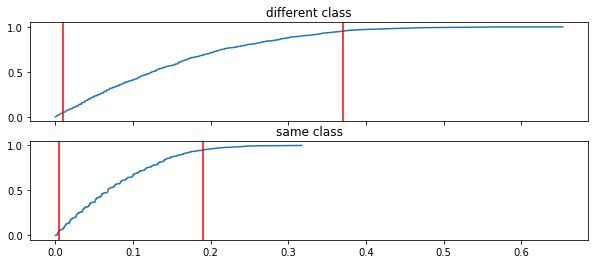

In [15]:
y, x = zip(*make_cdf(test_diff))

def find_nearest_idx(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

y = np.array(y)
x = np.array(x)

start = x[find_nearest_idx(y, 0.05)]
end = x[find_nearest_idx(y, 0.95)]
print('different class 95% CI - {} {}'.format(start, end))

f, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 4))
ax = ax.reshape(-1)

ax[0].plot(x, y)
ax[0].axvline(start, color='red')
ax[0].axvline(end, color='red')
ax[0].set_title('different class')

y, x = zip(*make_cdf(test_same))

y = np.array(y)
x = np.array(x)

start = x[find_nearest_idx(y, 0.05)]
end = x[find_nearest_idx(y, 0.95)]
print('same class 95% CI - {} {}'.format(start, end))

ax[1].plot(x, y)
ax[1].axvline(start, color='red')
ax[1].axvline(end, color='red')
_ = ax[1].set_title('same class')

## Practical - testing a correlation

Use the same structure above to get a p-value for the Pearson correlation
- the correlation between on mean sepal width (cm) vs mean sepal length (cm)
- calc test stats
- how often is our observed difference more extreme -> p-value

## Non-resampling approaches to hypothesis intervals

Developed in the 1930's when resampling was impossible

t-test
- standardized version of the test statistic
- Student's t distribution
- approximates the distribution of a single sample mean
- numeric data only

The resampling approaches we structure the hypothesis testing problem to reflect the data

## Chi-Squared tests

A simple variation on how we calculate the test statistic.  **We square the deviations** rather than take the absolute (this gives more weight to outliers):

$$ \chi^{2} = \sum_{i} \frac{(observed-expected)^2}{expected} $$

In [ ]:
def chi_sq(observed, expected):
    observed, expected = np.mean(observed), np.mean(expected)
    return (observed - expected)**2 / expected

p_val, test_chi = calc_p_val_mean_diff(first, second, iters=100, test_stat=chi_sq)
p_val

## Final thoughts on permutation to test a hypothesis

We can imagine variants of the shuffling we do above.  

One would be an **exhaustive permutation** (also known as exact tests) where we use every possible combination.  Another would be **bootstrap** sampling, where we sample with replacement.  Using a bootstrap will model not only the random assignment of A or B, but also the random element in the selection of subjects from a population.


## Statistical power

**How much data do I need to measure an effect**?
- large effect with small data = underpowered

Power of a test to detect an effect.  Depends on
- size of the effect you are looking for
- number of samples
- measurement error

If we think about false positives & negatives in the context of p-value hypothesis testing
- false positive = concluding that no effect is actually an effect
- false negative = concluding that a real effect is no effect

The false positive rate (how often we see chance as reality) is easy to compute - it is the threshold for significance (say 5%).

What about the false negative rate - how often will we miss seeing a real effect?
- this is harder to calculate because we need to know the true effect size
- what we can do is calculate a false negative rate conditioned on an assumed effect size

Lets assume our observed effect size.  How often do we miss this size effect?

In [17]:
def calc_statistical_power(first, second, trials=1000):
    count = 0
    for _ in range(trials):
        first_sample = np.random.choice(first, first.shape[0], replace=True)
        second_sample = np.random.choice(second, second.shape[0], replace=True)

        p_val, test_diff = calc_p_val_mean_diff(first_sample, second_sample, iters=100)

        if p_val > 0.05:
            count += 1

    print('If the actual effect size is {:.2f}, we expect to miss it {:.2f} % of the time'.format(
        np.mean(first) - np.mean(second), 100 * count / trials
    ))
    
first = features[target['setosa'] == 1].loc[:, 'sepal length (cm)'].values
second = features[target['virginica'] == 1].loc[:, 'sepal length (cm)'].values

calc_statistical_power(first, second, trials=1000)

If the actual effect size is -1.58, we expect to miss it 0.00 % of the time


In [19]:
mask = np.random.randint(0, 2, size=50).astype(bool)
setosa = features[target['setosa'] == 1]
first = setosa.loc[mask, 'sepal length (cm)']
second = setosa.loc[~mask, 'sepal length (cm)']

calc_statistical_power(first, second, trials=1000)

If the actual effect size is -0.04, we expect to miss it 90.00 % of the time


## Base rate fallacy

[Chapter 4 of Statistics Done Wrong](https://www.statisticsdonewrong.com/).

Low base rate -> many chances for false p

P-value tells you how probable your data is
- it doesn't tell you the probability of the effect

The probability of a false positive is almost always higher than the p-value
- in areas with low base rates (i.e. early stage drug trials) it is likely that many p < 0.05 results are false positives

## Examples

Testing drugs
- samples = 1000
- threshold p = 0.05
- base rate = 1% 
- statistical power = 80%
- we find 130 positives (80 true, balance false)

How many of drugs work? 10

How many will we detect? 8 = 10 * 0.8

False discovery rate = 1 - 8 / 13

How many false positives? (1000 - 10) * 0.05

What is the false positive rate? = 50 / (1000 - 130)

Breast cancer
- 1000 samples
- p = 0.07
- 0.8% base rate
- 0.9 statistical power

How many true positives are there? 8

How many will be discovered? 7 = 0.9 * 0.8 * 1000

How many false positives? 70 = 992 * 0.07

How many with positive test results actually have cancer? 7 / 77+8

## Multiple comparisons

More tests = greater chance of false positives

Functional MRI scans
- divide the brain scans into voxels
- compare blood flow in sequences of images
- many voxels -> many chances for false positives
- 'dead salmon' experiment - p=0.001 on an 81 mm3 area of the brain of a dead fish

Look-elsewhere effect an apparently statistically significant observation arises by chance because of the sheer size of the search

More tests = more chances for false positives
- tracking paitent symptoms over 12 weeks = 12 chances for false positives
- survey with 20 questions -> one false positive (at p=0.05)

Bonferroni correction rate
- threshold becomes $p/n$
- lowers false positive chance (but also reduces power)

Benjamini-Hochberg procedure
1. get p-value for $m$ comparisons
2. choose a false discovery rate $q$
3. find the largest $p$ such that $p \leq iq/m$ ($i$ = rank in list)
4. that value (and all smaller) are significant

Gives an upper bound on false posities of $q$

Cut off becomes more conservative if you 
- have a smaller false positive threshold ($q$)
- making more comparisons ($m$)

## Quiz

Why do we need to test the effects we see in data?

What does a p-value mean to you?

What is a Chi-Squared test?

What is statistical power?

What is the base rate fallacy?